# The overfitting problem

![](<src/09_Table_The Overfitting.png>)

## Load the data

In [85]:
import pandas as pd
df = pd.read_excel('data/microsoft-linkedin-processed.xlsx' , index_col=0)
df.index = pd.to_datetime(df.index)
df

,Close,High,Low,Open,Volume,change_tomorrow,change_tomorrow_direction
Price,,,,,,,
2016-12-01,59.200001,60.150002,58.939999,60.110001,34542100,0.084387,UP
2016-12-02,59.250000,59.470001,58.799999,59.080002,25515700,1.610763,UP
2016-12-05,60.220001,60.590000,59.560001,59.700001,23552700,-0.450376,DOWN
2016-12-06,59.950001,60.459999,59.799999,60.430000,19907000,2.313831,UP
2016-12-07,61.369999,61.380001,59.799999,60.009998,30809000,-0.590068,DOWN
...,...,...,...,...,...,...,...
2024-11-04,408.459991,410.420013,405.570007,409.799988,19672300,0.729111,UP
2024-11-05,411.459991,414.899994,408.079987,408.369995,17626000,2.075301,UP
2024-11-06,420.179993,420.450012,410.519989,412.420013,26681800,1.234046,UP


## Machine Learning Model

### Separate the data

1. Target: which variable do you want to predict?
2. Explanatory: which variables will you use to calculate the prediction?

In [86]:
target = df.change_tomorrow
explanatory = df[['Open','High','Low','Close','Volume']]

## Train test split

### Split the dataset

In [87]:
n_days = len(df.index)
n_days

1998

In [88]:
n_days_split = int(n_days*0.7)
n_days_split

1398

In [89]:
X_train, y_train = explanatory.iloc[:n_days_split], target.iloc[:n_days_split]
X_test, y_test = explanatory.iloc[n_days_split:], target.iloc[n_days_split:]

### Fit the model on train set

In [90]:
from sklearn.tree import DecisionTreeRegressor

In [133]:
model_dt_split = DecisionTreeRegressor(max_depth=19, random_state=42)

In [134]:
model_dt_split.fit(X=X_train, y=y_train)

DecisionTreeRegressor(max_depth=19, random_state=42)

### Evaluate model

#### On test set

In [135]:
from sklearn.metrics import mean_squared_error

y_pred_test = model_dt_split.predict(X=X_test)
y_pred_train = model_dt_split.predict(X=X_train)

train_error = mean_squared_error(y_true=y_train, y_pred=y_pred_train)
test_error  = mean_squared_error(y_true=y_test,  y_pred=y_pred_test)

print(f"Train rmse: {train_error}\nTest rmse: {test_error}")

Train rmse: 0.9973153794919618
Test rmse: 3.9255615552269347


#### On train set

## [ ] Backtesting

In [136]:
from backtesting import Backtest, Strategy

### Create the `Strategy`

In [144]:
class Regression(Strategy):
    limit_buy = 0
    limit_sell = -0
    
    def init(self):
        self.model = DecisionTreeRegressor(max_depth=5, random_state=42)
        self.already_bought = False
        self.model.fit(X=X_train, y=y_train)

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

### Run the backtest on `test` data

In [145]:
bt = Backtest(X_test, Regression,
              cash=10000, commission=.002, exclusive_orders=True)

In [146]:
results = bt.run(limit_buy=1, limit_sell=-5)

df_results_test = results.to_frame(name='Values').loc[:'Return [%]']\
    .rename({'Values':'Out of Sample (Test)'}, axis=1)
df_results_test

,Out of Sample (Test)
Start,2022-06-23 00:00:00
End,2024-11-08 00:00:00
Duration,869 days 00:00:00
Exposure Time [%],37.666667
Equity Final [$],11488.539568
Equity Peak [$],12629.019304
Return [%],14.885396


### Run the backtest on `train` data

In [147]:
bt = Backtest(X_train, Regression,
              cash=10000, commission=.002, exclusive_orders=True)

results = bt.run(limit_buy=1, limit_sell=-5)

df_results_train = results.to_frame(name='Values').loc[:'Return [%]']\
    .rename({'Values':'In Sample (Train)'}, axis=1)
df_results_train

,In Sample (Train)
Start,2016-12-01 00:00:00
End,2022-06-22 00:00:00
Duration,2029 days 00:00:00
Exposure Time [%],41.773963
Equity Final [$],16409.986422
Equity Peak [$],22339.285509
Return [%],64.099864


In [148]:
import matplotlib.pyplot as plt

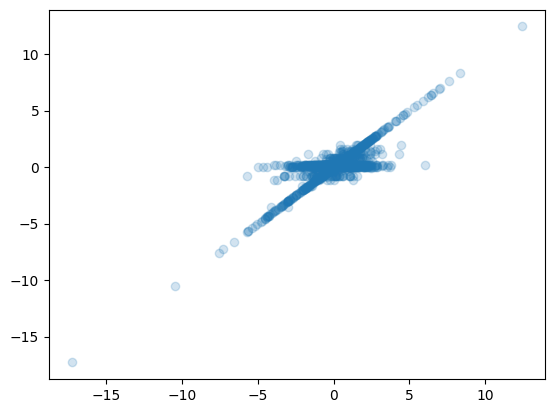

In [149]:
plt.scatter(y_train, y_pred_train, alpha=.2)

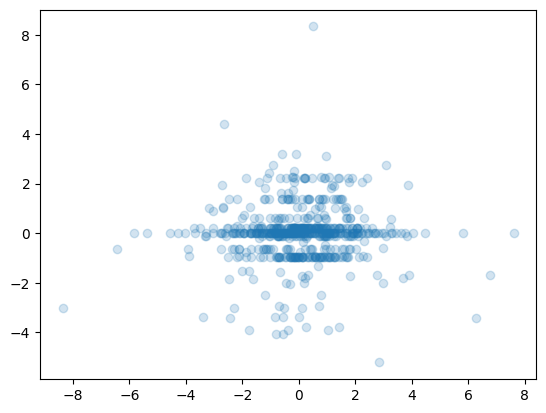

In [150]:
plt.scatter(y_test, y_pred_test, alpha=0.2)


### Compare both backtests

In [151]:
df_results = pd.concat([df_results_test, df_results_train], axis=1)
df_results

,Out of Sample (Test),In Sample (Train)
Start,2022-06-23 00:00:00,2016-12-01 00:00:00
End,2024-11-08 00:00:00,2022-06-22 00:00:00
Duration,869 days 00:00:00,2029 days 00:00:00
Exposure Time [%],37.666667,41.773963
Equity Final [$],11488.539568,16409.986422
Equity Peak [$],12629.019304,22339.285509
Return [%],14.885396,64.099864


## Practice to master the knowledge

Work on the challenge with another dataset:

1. Learn the <a>mental models</a> to solve the challenge faster.
2. Complete the <a href="09D_The Overfitting Problem.ipynb">notebook</a>.